<a href="https://colab.research.google.com/github/04-purnima/Appliances-Energy-Prediction/blob/main/Applilances_ENEGRY_Prediction_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
import xgboost as xgb
from sklearn import neighbors
from sklearn.svm import SVR
import time
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = ('/content/drive/MyDrive/Almabetter Notebooks/Capstone(Regression)/Data/data_application_energy.csv')
data = pd.read_csv(file_path, parse_dates=['date'])

#Studying the Data

In [ ]:
data.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [ ]:
data.shape

(19735, 29)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         19735 non-null  datetime64[ns]
 1   Appliances   19735 non-null  int64         
 2   lights       19735 non-null  int64         
 3   T1           19735 non-null  float64       
 4   RH_1         19735 non-null  float64       
 5   T2           19735 non-null  float64       
 6   RH_2         19735 non-null  float64       
 7   T3           19735 non-null  float64       
 8   RH_3         19735 non-null  float64       
 9   T4           19735 non-null  float64       
 10  RH_4         19735 non-null  float64       
 11  T5           19735 non-null  float64       
 12  RH_5         19735 non-null  float64       
 13  T6           19735 non-null  float64       
 14  RH_6         19735 non-null  float64       
 15  T7           19735 non-null  float64       
 16  RH_7

In [ ]:
# #Number of null values in all columns

data.isnull().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

In [ ]:
data.apply(lambda x: len(x.unique()))

date           19735
Appliances        92
lights             8
T1               722
RH_1            2547
T2              1650
RH_2            3376
T3              1426
RH_3            2618
T4              1390
RH_4            2987
T5              2263
RH_5            7571
T6              4446
RH_6            9709
T7              1955
RH_7            5891
T8              2228
RH_8            6649
T9               924
RH_9            3388
T_out           1730
Press_mm_hg     2189
RH_out           566
Windspeed        189
Visibility       413
Tdewpoint       1409
rv1            19735
rv2            19735
dtype: int64

In [ ]:
data.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


1. There are 29 columns - 1 date time column, 2 Integer columns and 26 Float column
 2. Nearly 1 coulmn (Lights) is having less than 10 unique items, which can be considered as categorical column
 3. There are NULL values in any of the given columns
 4. Target, which is Appliances need to predicted 

Observations
Temperature columns - Temperature inside the house varies between 14.89 Deg & 29.85 Deg , temperatire outside (T6) varies between -6.06 Deg to 28.29 Deg . The reason for this variation is sensors are kept outside the house

Humidiy columns - Humidity inside house varies is between 20.60% to 63.36% with exception of RH_5 (Bathroom) and RH_6 (Outside house) which varies between 29.82% to 96.32% and 1% to 99.9% respectively.

Appliances - 75% of Appliance consumption is less than 100 Wh . With the maximum consumption of 1080 Wh , there will be outliers in this column and there are small number of cases where consumption is very high

Lights column - Intially I believed lights column will be able to give useful information . With 11438 0 (zero) enteries in 14801 rows , this column will not add any value to the model . I believed light consumption along with humidity level in a room will give idea about human presence in the room and hence its impact on Appliance consumption. Hence for now , I will dropping this column

#Renaming the Columns

In [ ]:
temp = {
    'T1' : 'kitchen_temp', 'T2' : 'living_temp', 'T3' : 'laundry_temp', 
    'T4' : 'office_temp', 'T5' : 'bath_temp', 'T6' : 'outside_temp',
    'T7' : 'ironing_temp', 'T8' : 'teen_temp', 'T9' : 'parents_temp', 'T_out' : 'station_temp'
}

In [ ]:
energy = data.rename(columns=temp)

In [ ]:
humid = {
    'RH_1' : 'kitchen_humid', 'RH_2' : 'living_humid', 'RH_3' : 'laundry_humid', 
    'RH_4' : 'office_humid', 'RH_5' : 'bath_humid', 'RH_6' : 'outside_humid',
    'RH_7' : 'ironing_humid', 'RH_8' : 'teen_humid', 'RH_9' : 'parents_humid', 'RH_out' : 'station_humid'
}

In [ ]:
energy = energy.rename(columns=humid)

#Data Visualization

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
!pip install chart_studio

In [ ]:
import chart_studio.plotly as pyp
import plotly.graph_objs as go
import seaborn as sns
from matplotlib import pyplot as plt
import math
import datetime
from datetime import datetime
%matplotlib inline
import sklearn
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

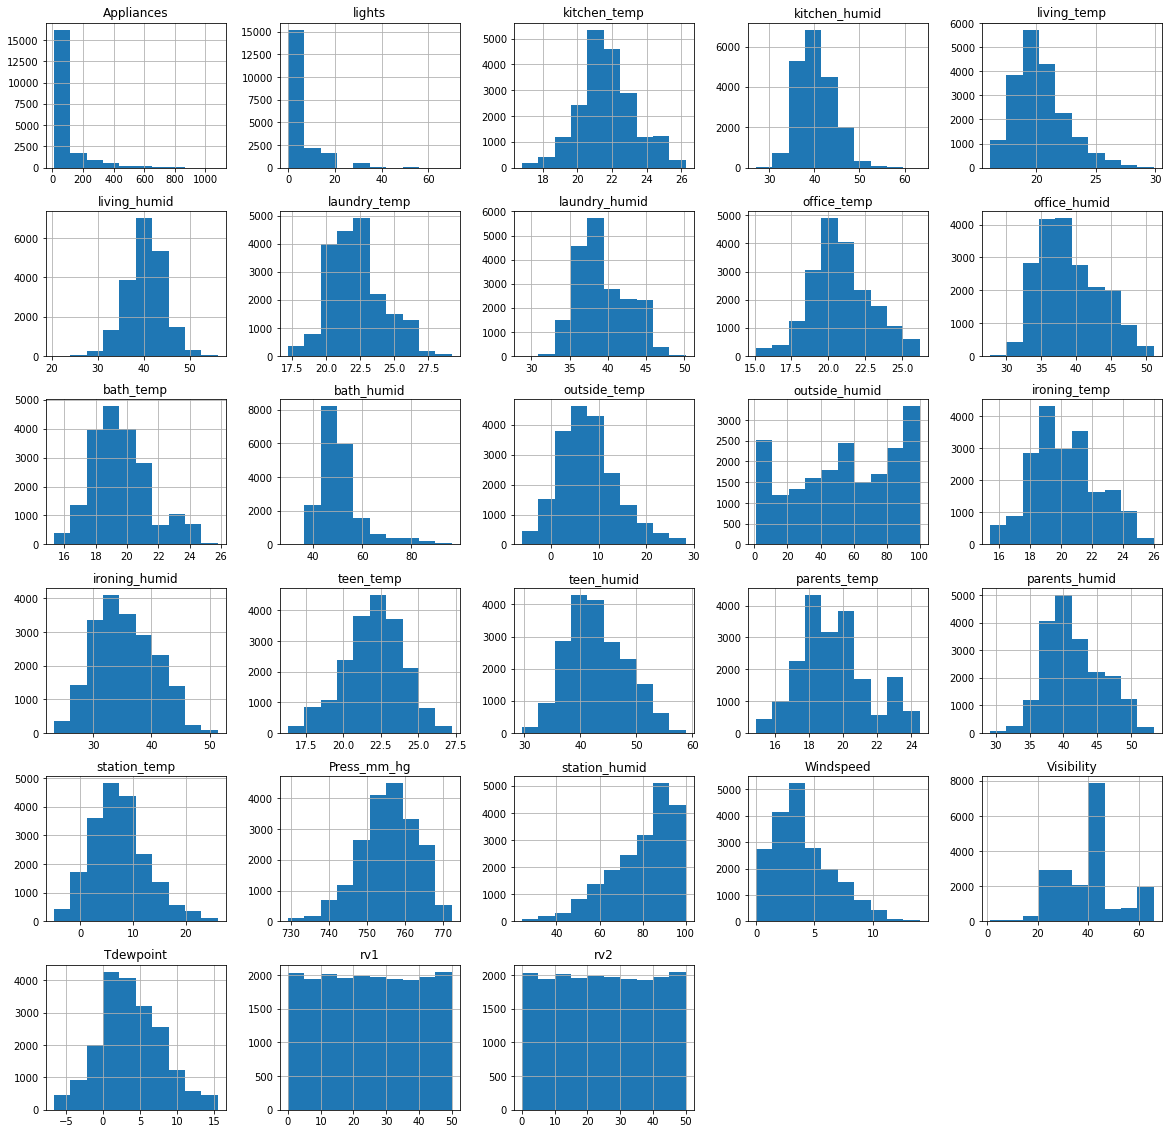

In [ ]:
p = energy.hist(figsize = (20,20))

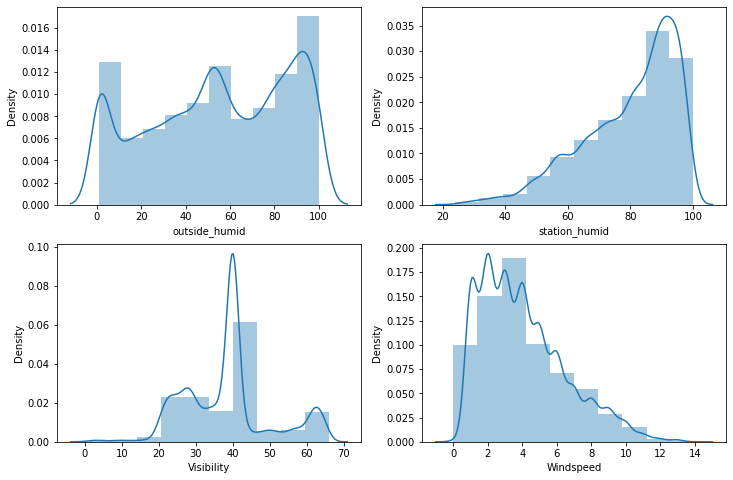

In [ ]:
# focussed displots for RH_6 , RH_out , Visibility , Windspeed due to irregular distribution
f, ax = plt.subplots(2,2,figsize=(12,8))
vis1 = sns.distplot(energy["outside_humid"],bins=10, ax= ax[0][0])
vis2 = sns.distplot(energy["station_humid"],bins=10, ax=ax[0][1])
vis3 = sns.distplot(energy["Visibility"],bins=10, ax=ax[1][0])
vis4 = sns.distplot(energy["Windspeed"],bins=10, ax=ax[1][1])

Observations⚡

Temperature - All the columns follow normal distribution except T9

Humidity - All columns follow normal distribution except RH_6 and RH_out , primarly because these sensors are outside the house

Visibilty - This column is negatively skewed

Windspeed - This column is postively skewed

In [ ]:
data.lights.value_counts()

0     15252
10     2212
20     1624
30      559
40       77
50        9
60        1
70        1
Name: lights, dtype: int64

As maximum value in lights attribute is 0, it wont be playing much role in our model. Hence we are dropping the lights attribute from our dataset.

In [ ]:
energy = energy.drop('lights', axis=1)

In [ ]:
energy.columns

Index(['date', 'Appliances', 'kitchen_temp', 'kitchen_humid', 'living_temp',
       'living_humid', 'laundry_temp', 'laundry_humid', 'office_temp',
       'office_humid', 'bath_temp', 'bath_humid', 'outside_temp',
       'outside_humid', 'ironing_temp', 'ironing_humid', 'teen_temp',
       'teen_humid', 'parents_temp', 'parents_humid', 'station_temp',
       'Press_mm_hg', 'station_humid', 'Windspeed', 'Visibility', 'Tdewpoint',
       'rv1', 'rv2'],
      dtype='object')

Check for outliers: We will consider as outliers the 0,1% top values of appliances' load because it is fact that recordings of power load higher than 800Wh from a house appliance are not logical. These may be false recordings caused by an instant fault on the recording devices. Additionally, in this data set there are not any NA value

In [ ]:
sorted_appliances=data.sort_values('Appliances', ascending=False)
sorted_appliances.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
731,2016-01-16 18:50:00,1080,30,21.930000,42.766667,21.040000,38.080000,20.700000,40.633333,20.89,39.733333,18.890000,51.881667,0.466667,96.090000,19.790,37.184286,20.926667,42.663333,17.79,40.672500,2.083333,765.033333,85.500000,3.666667,40.000000,-0.083333,27.408521,27.408521
1451,2016-01-21 18:50:00,1070,30,19.600000,34.300000,18.426667,33.963333,18.390000,36.930000,17.70,35.400000,17.856667,37.608333,-1.600000,90.933333,17.290,28.225000,19.356667,37.429444,16.00,36.930000,-0.616667,764.533333,82.833333,1.000000,64.166667,-3.216667,11.735734,11.735734
432,2016-01-14 17:00:00,910,0,21.463333,41.693333,20.856667,38.363333,21.666667,43.930000,18.70,42.660000,17.100000,53.000000,4.966667,74.166667,17.600,38.530000,18.200000,45.590000,17.00,43.466667,4.600000,747.900000,76.000000,7.000000,40.000000,0.700000,18.937972,18.937972
12088,2016-04-04 15:40:00,900,0,23.000000,43.166667,22.200000,40.426667,26.100000,38.930000,21.60,41.526667,20.890000,45.833333,16.830000,12.730000,21.790,36.466667,24.666667,42.526667,20.70,43.333333,14.766667,749.266667,59.666667,7.000000,40.000000,7.000000,15.105153,15.105153
1452,2016-01-21 19:00:00,890,20,19.730000,37.863333,18.566667,34.090000,18.390000,36.863333,17.60,35.133333,17.867778,37.728333,-1.730000,91.230000,17.235,28.153889,19.390000,37.228889,16.00,36.730000,-0.800000,764.500000,84.000000,1.000000,64.000000,-3.200000,3.221583,3.221583


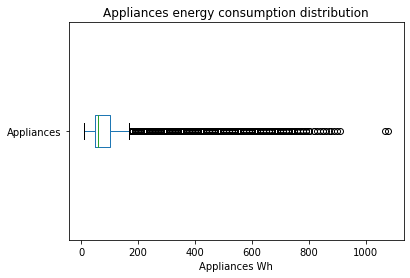

In [ ]:
ax = data.Appliances.plot.box(vert=False)
plt.xlabel('Appliances Wh')
plt.title('Appliances energy consumption distribution')
plt.show()

In [ ]:
energy[temp.values()].describe()

,kitchen_temp,living_temp,laundry_temp,office_temp,bath_temp,outside_temp,ironing_temp,teen_temp,parents_temp,station_temp
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,21.686571,20.341219,22.267611,20.855335,19.592106,7.910939,20.267106,22.029107,19.485828,7.411665
std,1.606066,2.192974,2.006111,2.042884,1.844623,6.090347,2.109993,1.956162,2.014712,5.317409
min,16.790000,16.100000,17.200000,15.100000,15.330000,-6.065000,15.390000,16.306667,14.890000,-5.000000
25%,20.760000,18.790000,20.790000,19.530000,18.277500,3.626667,18.700000,20.790000,18.000000,3.666667
50%,21.600000,20.000000,22.100000,20.666667,19.390000,7.300000,20.033333,22.100000,19.390000,6.916667
75%,22.600000,21.500000,23.290000,22.100000,20.619643,11.256000,21.600000,23.390000,20.600000,10.408333
max,26.260000,29.856667,29.236000,26.200000,25.795000,28.290000,26.000000,27.230000,24.500000,26.100000


Observations⚡:

Outside Average temperature over a period of 4.5 months is around 7.5 degrees and ranges from -6(min) to 28(max) degrees.

Inside the building avarage temperature has been around 20 degrees for all the rooms and ranges from 14(min) to 30(max) degrees.

Note: These points implies that warming appliances have been used to keep the insides of the building warm. There must be some sort of direct correlation b/w temperature and consumption of energy inside the house.

In [ ]:
energy[humid.values()].describe()

,kitchen_humid,living_humid,laundry_humid,office_humid,bath_humid,outside_humid,ironing_humid,teen_humid,parents_humid,station_humid
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,40.259739,40.420420,39.242500,39.026904,50.949283,54.609083,35.388200,42.936165,41.552401,79.750418
std,3.979299,4.069813,3.254576,4.341321,9.022034,31.149806,5.114208,5.224361,4.151497,14.901088
min,27.023333,20.463333,28.766667,27.660000,29.815000,1.000000,23.200000,29.600000,29.166667,24.000000
25%,37.333333,37.900000,36.900000,35.530000,45.400000,30.025000,31.500000,39.066667,38.500000,70.333333
50%,39.656667,40.500000,38.530000,38.400000,49.090000,55.290000,34.863333,42.375000,40.900000,83.666667
75%,43.066667,43.260000,41.760000,42.156667,53.663333,83.226667,39.000000,46.536000,44.338095,91.666667
max,63.360000,56.026667,50.163333,51.090000,96.321667,99.900000,51.400000,58.780000,53.326667,100.000000


Observations :

Outside the building average temp > average humidity inside the house.

Average humidity at the weather station > outside humidity near the building.

Average humidity in the bathroom > other rooms due to obvious reasons.

Kids and parent room show a comparatively higher average humidity.


# **Exploratory data analysis**

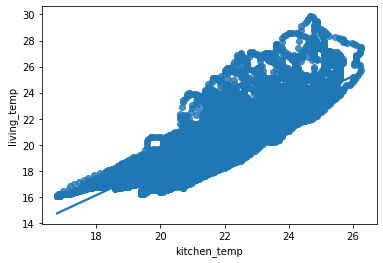

In [ ]:
sns.regplot(x=energy['kitchen_temp'], y=energy['living_temp'])

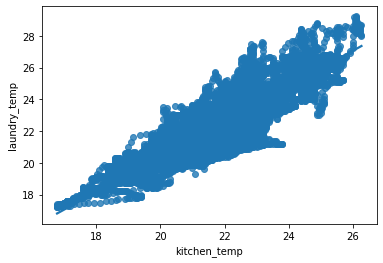

In [ ]:
sns.regplot(x=energy['kitchen_temp'], y=energy['laundry_temp'])

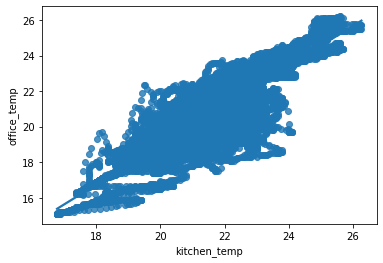

In [ ]:
sns.regplot(x=energy['kitchen_temp'], y=energy['office_temp'])

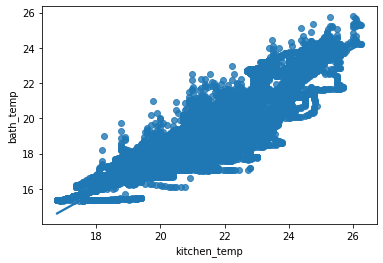

In [ ]:
sns.regplot(x=energy['kitchen_temp'], y=energy['bath_temp'])

# **Lets look at correlation matrix of temperature and humidity levels**

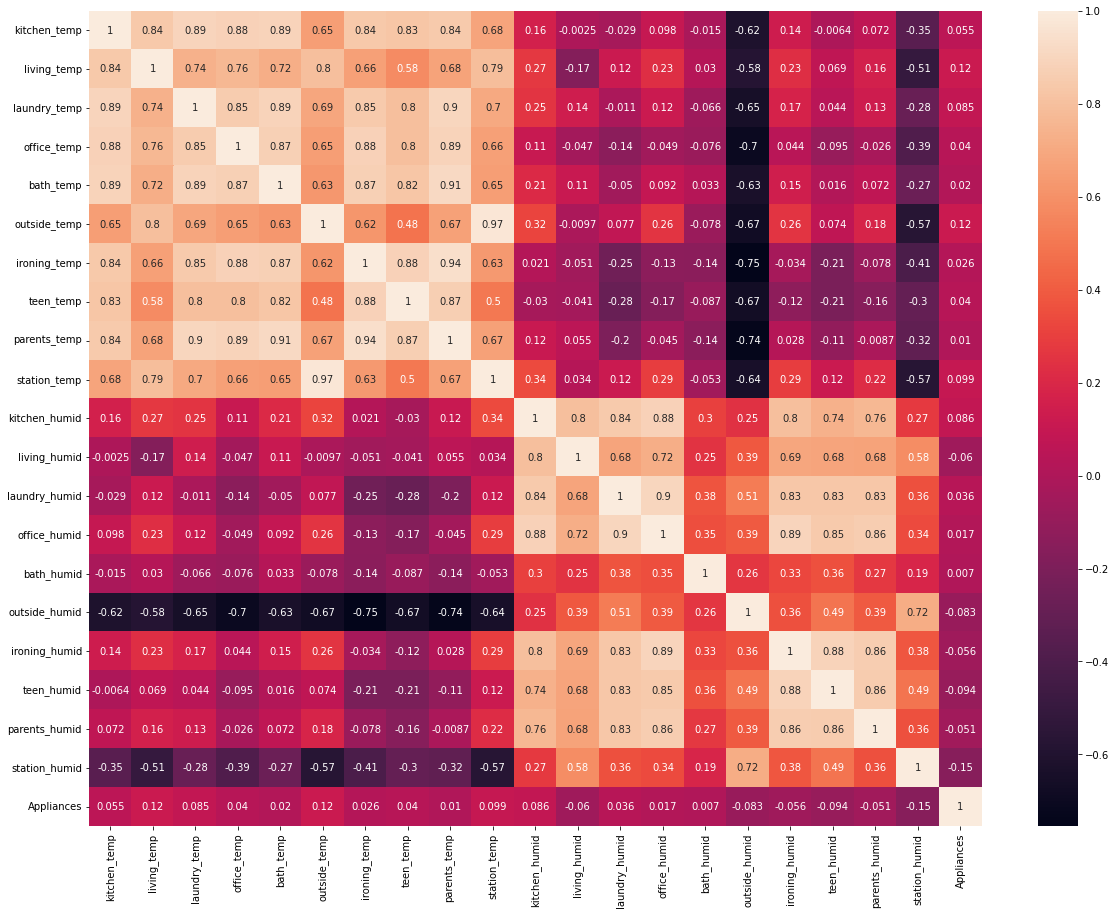

In [ ]:
cols = list(temp.values())
cols.extend(list(humid.values()))
cols.extend(['Appliances'])
fig, ax = plt.subplots(1,1,figsize=(20,15))
sns.heatmap(energy[cols].corr(), ax=ax, annot=True)

OBSERVATIONS ⚡:

From the correlation graph we clearly observe that the features related to temperature and features related to humidity have positive correlation within themselves whereas have a a very low or negative correlation with each other.

Humidity outside have a strong negative correlation with temperature levels.

Apart from that we observe that a couple features such as humidity at station, temperature outside the building and temperature in the living room have a comparatively high absolute correlation (above 0.12) with Appliances energy consumption.

Observations based on correlation plot
Temperature - All the temperature variables from T1-T9 and T_out have positive correlation with the target Appliances . For the indoortemperatures, the correlations are high as expected, since the ventilation is driven by the HRV unit and minimizes air tempera-ture differences between rooms. Four columns have a high degree of correlation with T9 - T3,T5,T7,T8 also T6 & T_Out has high correlation (both temperatures from outside) . Hence T6 & T9 can be removed from training set as information provided by them can be provided by other fields.

Weather attributes - Visibility, Tdewpoint, Press_mm_hg have low correlation values

Humidity - There are no significantly high correlation cases (> 0.9) for humidity sensors.

Random variables have no role to play

#Modelling/Splitting

In [ ]:
from sklearn.model_selection import train_test_split

# 75% of the data is used for the training of the models and the rest is used for testing
train, test = train_test_split(energy,test_size=0.25,random_state=40)

In [ ]:
train

,date,Appliances,kitchen_temp,kitchen_humid,living_temp,living_humid,laundry_temp,laundry_humid,office_temp,office_humid,bath_temp,bath_humid,outside_temp,outside_humid,ironing_temp,ironing_humid,teen_temp,teen_humid,parents_temp,parents_humid,station_temp,Press_mm_hg,station_humid,Windspeed,Visibility,Tdewpoint,rv1,rv2
9544,2016-03-17 23:40:00,70,22.600,34.700000,19.500000,37.863333,21.500000,35.345000,22.890000,33.663333,19.166667,71.263333,2.863333,57.826667,21.000000,26.890000,22.890000,38.500000,19.890000,37.260000,2.233333,764.200000,87.666667,1.333333,61.000000,0.400000,43.195492,43.195492
19366,2016-05-25 04:40:00,50,23.700,40.290000,21.000000,42.900000,25.390000,40.000000,23.600000,39.000000,19.890000,37.900000,5.500000,39.890000,23.000000,35.090000,24.200000,43.400000,22.600000,44.590000,6.266667,757.233333,93.666667,1.000000,25.333333,5.300000,46.369677,46.369677
10816,2016-03-26 19:40:00,100,22.200,45.800000,20.463333,44.930000,23.000000,38.560000,20.390000,43.596667,19.856667,50.026667,13.566667,33.500000,20.890000,37.000000,23.633333,43.800000,19.963333,41.363333,13.366667,750.133333,66.333333,6.333333,40.000000,7.133333,25.722968,25.722968
15457,2016-04-28 01:10:00,40,21.290,35.790000,18.230000,37.863333,21.290000,34.790000,20.533333,35.326667,19.290000,59.990000,0.066667,51.160000,19.500000,29.700000,22.200000,42.950000,18.890000,35.863333,0.316667,755.216667,94.333333,2.000000,20.166667,-0.450000,3.791656,3.791656
2956,2016-02-01 05:40:00,50,21.290,47.400000,20.290000,47.290000,21.666667,46.760000,18.790000,49.200000,19.475556,52.175556,10.800000,99.900000,19.044444,51.025000,20.926667,57.500000,17.600000,52.900000,10.766667,758.666667,92.666667,6.666667,59.000000,9.633333,8.706206,8.706206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,2016-03-31 19:00:00,100,21.760,41.933333,20.000000,43.163333,22.000000,38.466667,20.600000,40.700000,20.100000,48.500000,8.226667,56.326667,20.200000,33.790000,24.463333,39.693333,20.000000,38.863333,8.100000,754.800000,82.000000,2.000000,40.000000,5.200000,36.275509,36.275509
16065,2016-05-02 06:30:00,80,21.200,36.433333,18.000000,40.200000,22.100000,35.090000,20.260000,34.363333,19.600000,46.290000,1.730000,40.193333,19.290000,29.700000,22.290000,41.566667,19.600000,39.480000,1.750000,764.700000,92.500000,1.000000,27.500000,0.650000,37.879262,37.879262
14501,2016-04-21 09:50:00,50,21.600,37.466667,22.200000,35.700000,22.700000,35.700000,22.390000,34.790000,20.000000,45.433333,13.066667,6.696667,21.290000,32.290000,21.500000,39.200000,20.290000,37.900000,9.966667,762.616667,67.500000,4.000000,27.166667,4.100000,22.496162,22.496162
14555,2016-04-21 18:50:00,120,23.175,37.722500,22.856667,35.560000,23.290000,36.590000,22.890000,34.507500,21.166667,40.333333,18.600000,1.000000,22.238571,30.057143,22.823333,38.433333,20.200000,36.363333,17.366667,759.633333,47.500000,4.000000,38.166667,5.916667,32.362623,32.362623


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
import xgboost as xgb
from sklearn import neighbors
from sklearn.svm import SVR
import time
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from tensorflow.keras import Sequential, layers, Input

In [ ]:
train.shape

(14801, 28)

In [ ]:
humid.values()

dict_values(['kitchen_humid', 'living_humid', 'laundry_humid', 'office_humid', 'bath_humid', 'outside_humid', 'ironing_humid', 'teen_humid', 'parents_humid', 'station_humid'])

In [ ]:
temp.values()

dict_values(['kitchen_temp', 'living_temp', 'laundry_temp', 'office_temp', 'bath_temp', 'outside_temp', 'ironing_temp', 'teen_temp', 'parents_temp', 'station_temp'])

In [ ]:
energy.columns

Index(['date', 'Appliances', 'kitchen_temp', 'kitchen_humid', 'living_temp',
       'living_humid', 'laundry_temp', 'laundry_humid', 'office_temp',
       'office_humid', 'bath_temp', 'bath_humid', 'outside_temp',
       'outside_humid', 'ironing_temp', 'ironing_humid', 'teen_temp',
       'teen_humid', 'parents_temp', 'parents_humid', 'station_temp',
       'Press_mm_hg', 'station_humid', 'Windspeed', 'Visibility', 'Tdewpoint',
       'rv1', 'rv2'],
      dtype='object')

In [ ]:
# Divide the columns based on type for clear column management 

col_temp = ['kitchen_temp', 'living_temp', 'laundry_temp', 'office_temp', 'bath_temp', 'outside_temp', 'ironing_temp', 'teen_temp', 'parents_temp']

col_hum = ['kitchen_humid', 'living_humid', 'laundry_humid', 'office_humid', 'bath_humid', 'outside_humid', 'ironing_humid', 'teen_humid', 'parents_humid']

col_weather = ['station_temp', 'Tdewpoint','station_humid',"Press_mm_hg",
                "Windspeed","Visibility"] 
col_light = ["lights"]

col_randoms = ["rv1", "rv2"]

col_target = ["Appliances"]

In [ ]:
# Seperate dependent and independent variables 
feature_vars = train[col_temp + col_hum + col_weather]
target_vars=train[col_target]

In [ ]:
#Split training dataset into independent and dependent varibales
X_train = train[feature_vars.columns]
y_train = train[target_vars.columns]

In [ ]:
#Split testing dataset into independent and dependent varibales
X_test = test[feature_vars.columns]
y_test = test[target_vars.columns]

In [ ]:
X_train.columns

Index(['kitchen_temp', 'living_temp', 'laundry_temp', 'office_temp',
       'bath_temp', 'outside_temp', 'ironing_temp', 'teen_temp',
       'parents_temp', 'kitchen_humid', 'living_humid', 'laundry_humid',
       'office_humid', 'bath_humid', 'outside_humid', 'ironing_humid',
       'teen_humid', 'parents_humid', 'station_temp', 'Tdewpoint',
       'station_humid', 'Press_mm_hg', 'Windspeed', 'Visibility'],
      dtype='object')

In [ ]:
X_test.columns

Index(['kitchen_temp', 'living_temp', 'laundry_temp', 'office_temp',
       'bath_temp', 'outside_temp', 'ironing_temp', 'teen_temp',
       'parents_temp', 'kitchen_humid', 'living_humid', 'laundry_humid',
       'office_humid', 'bath_humid', 'outside_humid', 'ironing_humid',
       'teen_humid', 'parents_humid', 'station_temp', 'Tdewpoint',
       'station_humid', 'Press_mm_hg', 'Windspeed', 'Visibility'],
      dtype='object')

In [ ]:
X_test.shape

(4934, 24)

#Standardization

In [ ]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [ ]:
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train.values.reshape([-1,1])).flatten()
y_test = sc_y.transform(y_test.values.reshape([-1,1])).flatten()

In [ ]:
y_train.shape,X_test.shape,X_train.shape,y_test.shape

((14801,), (4934, 24), (14801, 24), (4934,))

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn import neighbors
from sklearn.svm import SVR

In [ ]:
models = [
           ['Lasso: ', Lasso()],
           ['Ridge: ', Ridge()],
           ['KNeighborsRegressor: ',  neighbors.KNeighborsRegressor()],
           ['SVR:' , SVR(kernel='rbf')],
           ['RandomForest ',RandomForestRegressor()],
           ['ExtraTreeRegressor :',ExtraTreesRegressor()],
           ['GradientBoostingClassifier: ', GradientBoostingRegressor()] ,
           ['XGBRegressor: ', xgb.XGBRegressor()] 
]

In [ ]:
# Run all the proposed models and update the information in a list model_data

model_data = []
for name,curr_model in models :
    curr_model_data = {}
    curr_model.random_state = 78
    curr_model_data["Name"] = name
    start = time.time()
    curr_model.fit(X_train,y_train)
    end = time.time()
    curr_model_data["Train_Time"] = end - start
    curr_model_data["Train_R2_Score"] = r2_score(y_train,curr_model.predict(X_train))
    curr_model_data["Test_R2_Score"] = r2_score(y_test,curr_model.predict(X_test))
    curr_model_data["Test_RMSE_Score"] = np.sqrt(mean_squared_error(y_test,curr_model.predict(X_test)))
    model_data.append(curr_model_data)

[09:56:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
results_df = data = pd.DataFrame(model_data)

In [ ]:
results_df

,Name,Train_Time,Train_R2_Score,Test_R2_Score,Test_RMSE_Score
0,Lasso:,0.007166,0.000000,-0.000031,0.984268
1,Ridge:,0.004622,0.149661,0.134760,0.915535
2,KNeighborsRegressor:,0.000772,0.679698,0.485718,0.705842
3,SVR:,12.132063,0.239142,0.213973,0.872620
4,RandomForest,33.527877,0.939153,0.587949,0.631804
5,ExtraTreeRegressor :,8.435473,1.000000,0.647956,0.583990
6,GradientBoostingClassifier:,7.908449,0.336856,0.257351,0.848200
7,XGBRegressor:,1.609978,0.324972,0.242367,0.856715


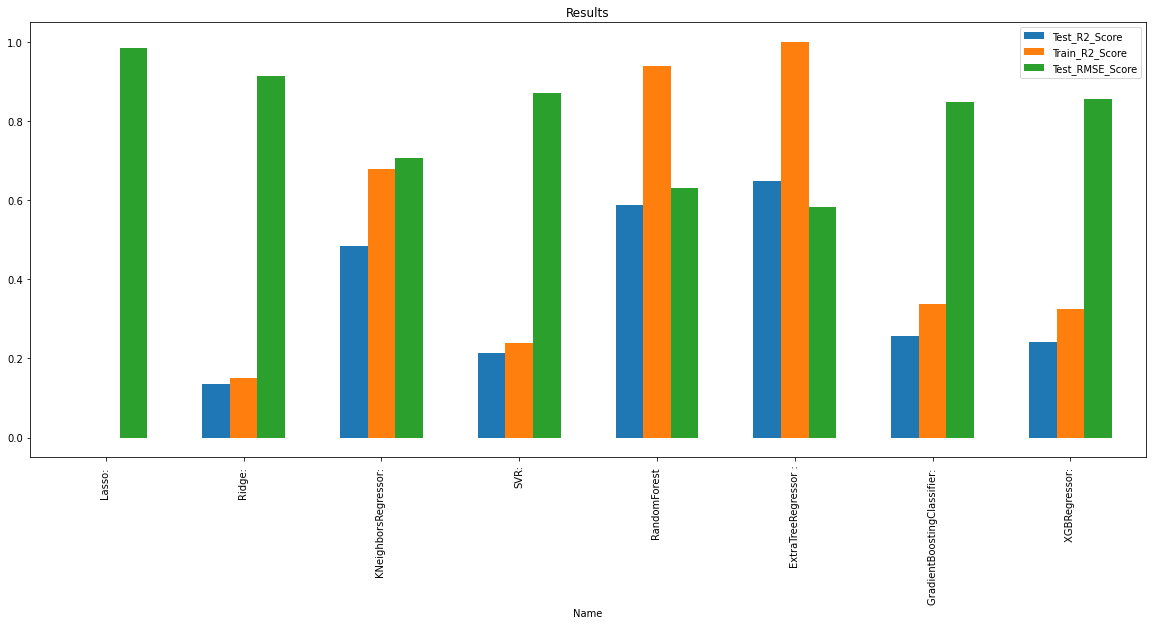

In [ ]:
results_df.plot.bar(x="Name", y=['Test_R2_Score' , 'Train_R2_Score' , 'Test_RMSE_Score'], title = 'Results' , width = .6, figsize= (20,8))

Obervations⚡

Best results over test set are given by Extra Tree Regressor with R2 score. of 0.64

Least RMSE score is also by Extra Tree Regressor 0.58.

Lasso regularization over Linear regression was worst performing model.

#HyperParameter Tunning

ExtraTreesRegressor

In [ ]:
param_grid = [{
              'max_depth': [80, 150, 200,250],
              'n_estimators' : [100,150,200,250],
              'max_features': ["auto", "sqrt", "log2"]
            }]
reg = ExtraTreesRegressor(random_state=40)
grid_search = GridSearchCV(estimator = reg, param_grid = param_grid, cv = 5, n_jobs = -1 , scoring='r2' , verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=ExtraTreesRegressor(random_state=40), n_jobs=-1,
             param_grid=[{'max_depth': [80, 150, 200, 250],
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'n_estimators': [100, 150, 200, 250]}],
             scoring='r2', verbose=2)

In [ ]:
grid_search.best_params_

{'max_depth': 80, 'max_features': 'sqrt', 'n_estimators': 250}

In [ ]:
grid_search.best_estimator_

ExtraTreesRegressor(max_depth=80, max_features='sqrt', n_estimators=250,
                    random_state=40)

In [ ]:
grid_search.best_estimator_.score(X_train,y_train)

0.9999995694308664

In [ ]:
grid_search.best_estimator_.score(X_test,y_test)

0.651122216966884

In [ ]:
np.sqrt(mean_squared_error(y_test, grid_search.best_estimator_.predict(X_test)))

59.8361306262027

Observations¶
Based on parameter tunning step we can see that

Best possible parameter combination are - 'max_depth': 80, 'max_features': 'sqrt', 'n_estimators': 200


Training set R2 score of 1.0 may be signal of overfitting on training set


Test set R2 score is 0.65 improvement over 0.64 achieved using untuned model


Test set RMSE score is 0.59 improvement over 0.65 achieved using untuned model

#Feature Importance

In [ ]:
feature_v2=feature_vars.copy

In [ ]:
# Get sorted list of features in order of importance
feature_indices = np.argsort(grid_search.best_estimator_.feature_importances_)

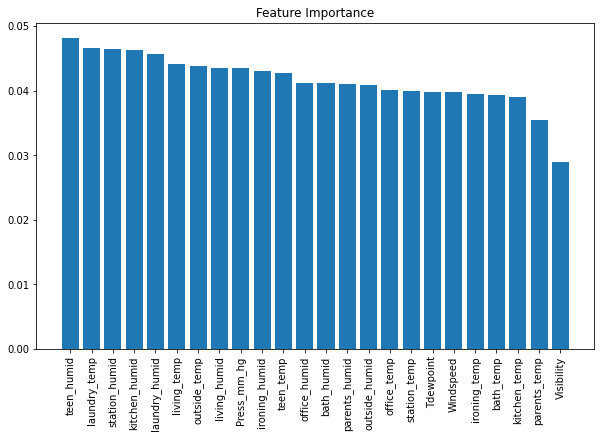

In [ ]:
importances = grid_search.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
names = [feature_vars.columns[i] for i in indices]
# Create plot
plt.figure(figsize=(10,6))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(feature_vars.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(feature_vars.shape[1]), names, rotation=90)

# Show plot
plt.show()

In [ ]:
# Get top 5 most important feature 
names[0:5]

['teen_humid',
 'laundry_temp',
 'station_humid',
 'kitchen_humid',
 'laundry_humid']

In [ ]:
# Get 5 least important feature 
names[-5:]

['ironing_temp', 'bath_temp', 'kitchen_temp', 'parents_temp', 'Visibility']